In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


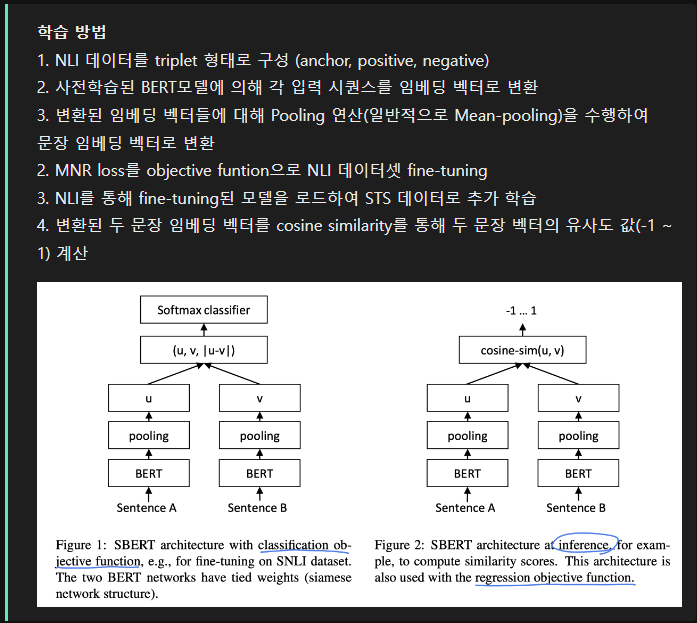

In [ ]:
# 본인의 실습 디렉토리로 변경
% cd /content/drive/MyDrive/Dev/my_workspace/NLP/sentence-transformers/bi-encoder-training

/content/drive/MyDrive/Dev/my_workspace/NLP/sentence-transformers


In [ ]:
! pip install sentence_transformers datasets

     |████████████████████████████████| 79 kB 3.7 MB/s 
     |████████████████████████████████| 312 kB 30.1 MB/s 
     |████████████████████████████████| 3.8 MB 33.5 MB/s 
     |████████████████████████████████| 1.2 MB 44.1 MB/s 
     |████████████████████████████████| 67 kB 4.4 MB/s 
     |████████████████████████████████| 6.5 MB 39.3 MB/s 
     |████████████████████████████████| 895 kB 42.7 MB/s 
     |████████████████████████████████| 596 kB 44.2 MB/s 
     |████████████████████████████████| 212 kB 47.1 MB/s 
     |████████████████████████████████| 1.1 MB 40.4 MB/s 
     |████████████████████████████████| 134 kB 51.4 MB/s 
     |████████████████████████████████| 127 kB 42.7 MB/s 
     |████████████████████████████████| 144 kB 45.5 MB/s 
     |████████████████████████████████| 271 kB 46.3 MB/s 
     |████████████████████████████████| 94 kB 3.3 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.0-py3-none-any.whl size=120747 sha256=a05dfc7176f23d17eb31

In [ ]:
import math
import numpy as np
import logging
from datetime import datetime

import torch
from torch.utils.data import DataLoader
from datasets import load_dataset
from sentence_transformers import SentenceTransformer, models, LoggingHandler, losses, util
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator
from sentence_transformers.readers import InputExample

In [ ]:
# logger
logging.basicConfig(
    format="%(asctime)s - %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
    level=logging.INFO,
    handlers=[LoggingHandler()],
)

In [ ]:
pretrained_model_name = 'klue/roberta-base'
nli_num_epochs = 1
sts_num_epochs = 4
train_batch_size = 32

nli_model_save_path = 'output/training_nli_by_Softmaxloss'+pretrained_model_name.replace("/", "-")+'-'+datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
sts_model_save_path = 'output/training_sts_continue_training-'+pretrained_model_name.replace("/", "-")+'-'+datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# 1. Load Dataset & Preprocessing

## 1.1. KLUE-NLI

In [ ]:
# load KLUE-NLI Dataset
klue_nli_train = load_dataset("klue", "nli", split='train')
print('Length of Train : ',len(klue_nli_train))

Downloading:   0%|          | 0.00/5.21k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.93k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.26M [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset klue downloaded and prepared to /root/.cache/huggingface/datasets/klue/nli/1.0.0/e0fc3bc3de3eb03be2c92d72fd04a60ecc71903f821619cb28ca0e1e29e4233e. Subsequent calls will reuse this data.
Length of Train :  24998


In [ ]:
klue_nli_train[0]

{'guid': 'klue-nli-v1_train_00000',
 'hypothesis': '힛걸 진심 최고로 멋지다.',
 'label': 0,
 'premise': '힛걸 진심 최고다 그 어떤 히어로보다 멋지다',
 'source': 'NSMC'}

In [ ]:
def make_nli_input_example(dataset):
    '''
    Transform to InputExample
    '''
    input_examples = []
    for i, data in enumerate(dataset):
        sentence1 = data['hypothesis']
        sentence2 = data['premise']
        label = data['label'] # 0(entailment), 1(neutral), 2(contradiction)
        input_examples.append(InputExample(texts=[sentence1, sentence2], label=label))

    return input_examples

In [ ]:
nli_train_examples = make_nli_input_example(klue_nli_train)

In [ ]:
# Train Dataloader
train_dataloader = DataLoader(
    nli_train_examples,
    shuffle=True,
    batch_size=train_batch_size,
)

## 1.2. KLUE-STS

In [ ]:
# load KLUE-STS Dataset
klue_sts_train = load_dataset("klue", "sts", split='train[:90%]')
klue_sts_valid = load_dataset("klue", "sts", split='train[-10%:]') # train의 10%를 validation set으로 사용
klue_sts_test = load_dataset("klue", "sts", split='validation')

print('Length of Train : ',len(klue_sts_train))
print('Length of Valid : ',len(klue_sts_valid))
print('Length of Test : ',len(klue_sts_test))

Downloading:   0%|          | 0.00/1.35M [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset klue downloaded and prepared to /root/.cache/huggingface/datasets/klue/sts/1.0.0/e0fc3bc3de3eb03be2c92d72fd04a60ecc71903f821619cb28ca0e1e29e4233e. Subsequent calls will reuse this data.
2022-03-10 05:21:00 - Reusing dataset klue (/root/.cache/huggingface/datasets/klue/sts/1.0.0/e0fc3bc3de3eb03be2c92d72fd04a60ecc71903f821619cb28ca0e1e29e4233e)
2022-03-10 05:21:01 - Reusing dataset klue (/root/.cache/huggingface/datasets/klue/sts/1.0.0/e0fc3bc3de3eb03be2c92d72fd04a60ecc71903f821619cb28ca0e1e29e4233e)
Length of Train :  10501
Length of Valid :  1167
Length of Test :  519


In [ ]:
klue_sts_train[0]

{'guid': 'klue-sts-v1_train_00000',
 'labels': {'binary-label': 1, 'label': 3.7, 'real-label': 3.714285714285714},
 'sentence1': '숙소 위치는 찾기 쉽고 일반적인 한국의 반지하 숙소입니다.',
 'sentence2': '숙박시설의 위치는 쉽게 찾을 수 있고 한국의 대표적인 반지하 숙박시설입니다.',
 'source': 'airbnb-rtt'}

In [ ]:
def make_sts_input_example(dataset):
    '''
    Transform to InputExample
    '''
    input_examples = []
    for i, data in enumerate(dataset):
        sentence1 = data['sentence1']
        sentence2 = data['sentence2']
        score = (data['labels']['label']) / 5.0  # normalize 0 to 5
        input_examples.append(InputExample(texts=[sentence1, sentence2], label=score))

    return input_examples

In [ ]:
sts_train_examples = make_sts_input_example(klue_sts_train)
sts_valid_examples = make_sts_input_example(klue_sts_valid)
sts_test_examples = make_sts_input_example(klue_sts_test)

In [ ]:
# Train Dataloader
train_dataloader = DataLoader(
    sts_train_examples,
    shuffle=True,
    batch_size=train_batch_size,
)

# Evaluator by sts-validation
dev_evaluator = EmbeddingSimilarityEvaluator.from_input_examples(
    sts_valid_examples,
    name="sts-dev",
)

# Evaluator by sts-test
test_evaluator = EmbeddingSimilarityEvaluator.from_input_examples(
    sts_test_examples,
    name="sts-test",
)

# 2. Load Embedding Model

In [ ]:
# Load Embedding Model
embedding_model = models.Transformer(
    model_name_or_path=pretrained_model_name,
    max_seq_length=256,
    do_lower_case=True
)

# Only use Mean Pooling -> Pooling all token embedding vectors of sentence.
pooling_model = models.Pooling(
    embedding_model.get_word_embedding_dimension(),
    pooling_mode_mean_tokens=True,
    pooling_mode_cls_token=False,
    pooling_mode_max_tokens=False,
)

model = SentenceTransformer(modules=[embedding_model, pooling_model])

Some weights of the model checkpoint at klue/roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.decoder.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for

2022-03-10 05:23:56 - Use pytorch device: cuda


# 3. Training by NLI
- Trainset: nli-train
- Devset: sts-dev

In [ ]:
# Use SoftmaxLoss, because NLI is Multi-class Classification task.
train_loss = losses.SoftmaxLoss(
    model=model,
    sentence_embedding_dimension=model.get_sentence_embedding_dimension(),
    num_labels=3 # entailment, neutral, contradiction
)

# warmup steps
warmup_steps = math.ceil(len(nli_train_examples) * nli_num_epochs / train_batch_size * 0.1) #10% of train data for warm-up
logging.info("Warmup-steps: {}".format(warmup_steps))

# Training
model.fit(
    train_objectives=[(train_dataloader, train_loss)],
    evaluator=dev_evaluator,
    epochs=nli_num_epochs,
    evaluation_steps=int(len(train_dataloader)*0.1),
    warmup_steps=warmup_steps,
    output_path=nli_model_save_path
)

# 4. Training by STS (Continue Learning)

## 4.1. Load model of fine-tuning by NLI

In [ ]:
# Load model of fine-tuning by NLI
model = SentenceTransformer(nli_model_save_path)

2022-02-25 01:41:31 - Load pretrained SentenceTransformer: output/training_nli_klue-roberta-base-2022-02-25_01-35-00
2022-02-25 01:41:32 - Use pytorch device: cuda


## 4.2 Training

In [ ]:
# Use CosineSimilarityLoss
train_loss = losses.CosineSimilarityLoss(model=model)

# warmup steps
warmup_steps = math.ceil(len(sts_train_examples) * sts_num_epochs / train_batch_size * 0.1) #10% of train data for warm-up
logging.info("Warmup-steps: {}".format(warmup_steps))

# Training
model.fit(
    train_objectives=[(train_dataloader, train_loss)],
    evaluator=dev_evaluator,
    epochs=sts_num_epochs,
    evaluation_steps=int(len(train_dataloader)*0.1),
    warmup_steps=warmup_steps,
    output_path=sts_model_save_path
)

2022-02-25 01:41:32 - Warmup-steps: 132


/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Iteration:   0%|          | 0/329 [00:00<?, ?it/s]

2022-02-25 01:44:24 - EmbeddingSimilarityEvaluator: Evaluating the model on sts-dev dataset after epoch 0:
2022-02-25 01:44:28 - Cosine-Similarity :	Pearson: 0.9544	Spearman: 0.9157
2022-02-25 01:44:28 - Manhattan-Distance:	Pearson: 0.9473	Spearman: 0.9123
2022-02-25 01:44:28 - Euclidean-Distance:	Pearson: 0.9476	Spearman: 0.9127
2022-02-25 01:44:28 - Dot-Product-Similarity:	Pearson: 0.9506	Spearman: 0.9077
2022-02-25 01:44:28 - Save model to output/training_sts_continue_training-klue-roberta-base-2022-02-25_01-35-00


Iteration:   0%|          | 0/329 [00:00<?, ?it/s]

2022-02-25 01:47:19 - EmbeddingSimilarityEvaluator: Evaluating the model on sts-dev dataset after epoch 1:
2022-02-25 01:47:23 - Cosine-Similarity :	Pearson: 0.9573	Spearman: 0.9206
2022-02-25 01:47:23 - Manhattan-Distance:	Pearson: 0.9501	Spearman: 0.9173
2022-02-25 01:47:23 - Euclidean-Distance:	Pearson: 0.9504	Spearman: 0.9174
2022-02-25 01:47:23 - Dot-Product-Similarity:	Pearson: 0.9533	Spearman: 0.9116
2022-02-25 01:47:23 - Save model to output/training_sts_continue_training-klue-roberta-base-2022-02-25_01-35-00


Iteration:   0%|          | 0/329 [00:00<?, ?it/s]

2022-02-25 01:50:19 - EmbeddingSimilarityEvaluator: Evaluating the model on sts-dev dataset after epoch 2:
2022-02-25 01:50:23 - Cosine-Similarity :	Pearson: 0.9597	Spearman: 0.9234
2022-02-25 01:50:23 - Manhattan-Distance:	Pearson: 0.9516	Spearman: 0.9194
2022-02-25 01:50:23 - Euclidean-Distance:	Pearson: 0.9519	Spearman: 0.9196
2022-02-25 01:50:23 - Dot-Product-Similarity:	Pearson: 0.9538	Spearman: 0.9123
2022-02-25 01:50:23 - Save model to output/training_sts_continue_training-klue-roberta-base-2022-02-25_01-35-00


Iteration:   0%|          | 0/329 [00:00<?, ?it/s]

2022-02-25 01:53:18 - EmbeddingSimilarityEvaluator: Evaluating the model on sts-dev dataset after epoch 3:
2022-02-25 01:53:22 - Cosine-Similarity :	Pearson: 0.9599	Spearman: 0.9241
2022-02-25 01:53:22 - Manhattan-Distance:	Pearson: 0.9518	Spearman: 0.9202
2022-02-25 01:53:22 - Euclidean-Distance:	Pearson: 0.9521	Spearman: 0.9203
2022-02-25 01:53:22 - Dot-Product-Similarity:	Pearson: 0.9537	Spearman: 0.9119
2022-02-25 01:53:22 - Save model to output/training_sts_continue_training-klue-roberta-base-2022-02-25_01-35-00


# 5. Evaluation

In [ ]:
# evaluation sts-test
test_evaluator(model, output_path=sts_model_save_path)

2022-02-25 01:53:26 - EmbeddingSimilarityEvaluator: Evaluating the model on sts-test dataset:
2022-02-25 01:53:28 - Cosine-Similarity :	Pearson: 0.8790	Spearman: 0.8797
2022-02-25 01:53:28 - Manhattan-Distance:	Pearson: 0.8760	Spearman: 0.8730
2022-02-25 01:53:28 - Euclidean-Distance:	Pearson: 0.8761	Spearman: 0.8730
2022-02-25 01:53:28 - Dot-Product-Similarity:	Pearson: 0.8716	Spearman: 0.8692


0.8796588987336235